
## Purpose

Test out clusterProfiler

## Load libraries


In [1]:
# Bioconductor
library(clusterProfiler)
#library(paxtoolsr)

# CRAN
library(wordcloud)
library(tm)
library(igraph)
library(magrittr)
library(dplyr)
library(jsonlite)

source("readGmt.R")
source("toCytoscape.R")

Loading required package: DOSE

DOSE v3.2.0  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609

clusterProfiler v3.4.4  For help: https://guangchuangyu.github.io/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu., Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.
Loading required package: RColorBrewer
Loading required package: NLP

Attaching package: ‘igraph’

The following object is masked from ‘package:clusterProfiler’:

    simplify

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attachi


## Load Gene Sets
### Bader EnrichmentMap


In [2]:
lowerBound <- 3
upperBound <- 100

lovGmt <- readGmt("Human_GOBP_AllPathways_no_GO_iea_February_01_2017_symbol.gmt")
xCnts <- unlist(lapply(lovGmt, length))
idx <- which(xCnts > lowerBound & xCnts < upperBound)
which.max(xCnts[idx])
length(lovGmt[[1435]])

orgNames <- names(lovGmt)

smNames <- NULL
for(i in 1:length(lovGmt)) {
  t1 <- names(lovGmt)[i]
  t2 <- strsplit(t1, "%")
  smNames <- c(smNames, t2[[1]][1])
}

CLEC7A (DECTIN-1) SIGNALING%REACTOME%R-HSA-5607764.1 
                                                1435

[1] 78


## Load GMT


In [3]:
emGmt <- readRDS("emGmt.rds")

gmt <- emGmt


## Load Example Data


In [4]:
# DDR genes
genes <- c("EID3", "EME1", "EME2", "GEN1", 
              "H2AFX", "HFM1", "MRE11A", "MUS81", "NBN", "NDNL2", "NFATC2IP", 
              "NSMCE1", "NSMCE2", "NSMCE4A", "PAXIP1", "PPP4C", "PPP4R1", "PPP4R2", 
              "PPP4R4", "RAD50", "RAD51B", "RAD51D", "RAD52", "RAD54B", "RAD54L", 
              "RDM1", "RECQL", "RECQL4", "RECQL5", "SHFM1", "SLX1A", "SLX4", 
              "SMC5", "SMC6", "SPO11", "UIMC1")
genes <- sample(genes, 15)
genes

[1] "EID3"   "H2AFX"  "PAXIP1" "SMC6"   "RECQL"  "UIMC1"  "RAD52"  "RAD51D"
 [9] "RAD50"  "PPP4R2" "EME1"   "SMC5"   "PPP4C"  "RAD51B" "RECQL4"


## Run Enrichment Analyses


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
NON-RECOMBINATIONAL REPAIR,NON-RECOMBINATIONAL REPAIR,NON-RECOMBINATIONAL REPAIR,6/14,71/12390,8.266502e-11,1.330907e-08,4.524822e-09,H2AFX/PAXIP1/UIMC1/RAD52/RAD50/SMC5,6
MITOTIC RECOMBINATION,MITOTIC RECOMBINATION,MITOTIC RECOMBINATION,5/14,44/12390,8.733781e-10,7.030694e-08,2.390298e-08,SMC6/RAD51D/RAD50/SMC5/RAD51B,5
DOUBLE-STRAND BREAK REPAIR VIA NONHOMOLOGOUS END JOINING,DOUBLE-STRAND BREAK REPAIR VIA NONHOMOLOGOUS END JOINING,DOUBLE-STRAND BREAK REPAIR VIA NONHOMOLOGOUS END JOINING,5/14,65/12390,6.558504e-09,3.519730e-07,1.196639e-07,H2AFX/PAXIP1/UIMC1/RAD50/SMC5,5
DOUBLE-STRAND BREAK REPAIR VIA HOMOLOGOUS RECOMBINATION,DOUBLE-STRAND BREAK REPAIR VIA HOMOLOGOUS RECOMBINATION,DOUBLE-STRAND BREAK REPAIR VIA HOMOLOGOUS RECOMBINATION,5/14,72/12390,1.106238e-08,3.655031e-07,1.242639e-07,RECQL/RAD51D/RAD50/SMC5/RAD51B,5
RECOMBINATIONAL REPAIR,RECOMBINATIONAL REPAIR,RECOMBINATIONAL REPAIR,5/14,73/12390,1.186858e-08,3.655031e-07,1.242639e-07,RECQL/RAD51D/RAD50/SMC5/RAD51B,5
REGULATION OF DNA REPAIR,REGULATION OF DNA REPAIR,REGULATION OF DNA REPAIR,5/14,75/12390,1.362123e-08,3.655031e-07,1.242639e-07,H2AFX/UIMC1/RAD52/PPP4R2/PPP4C,5


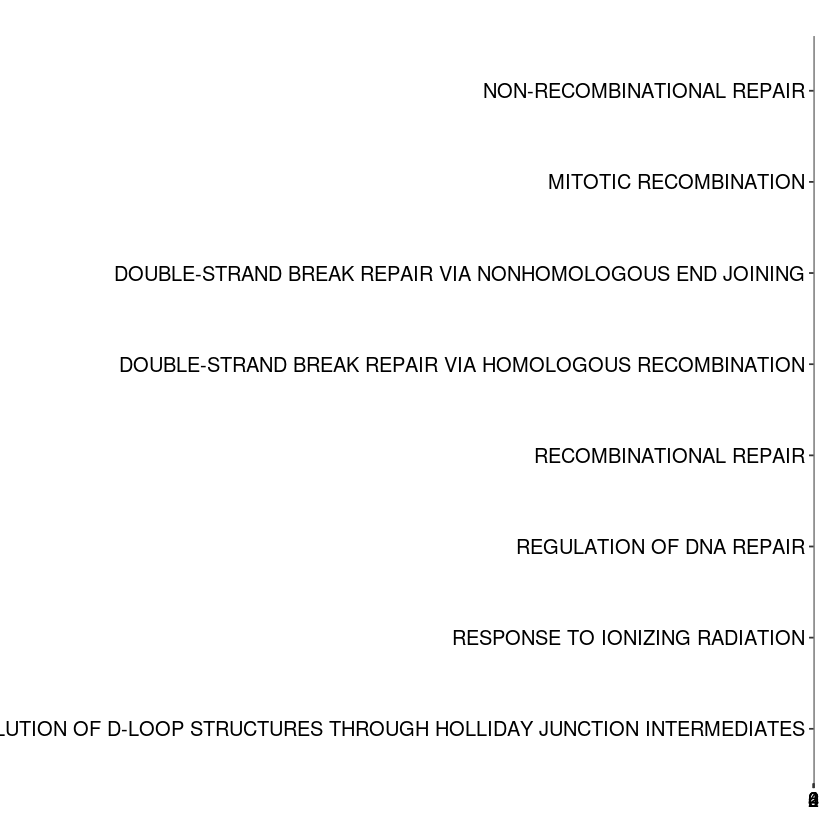

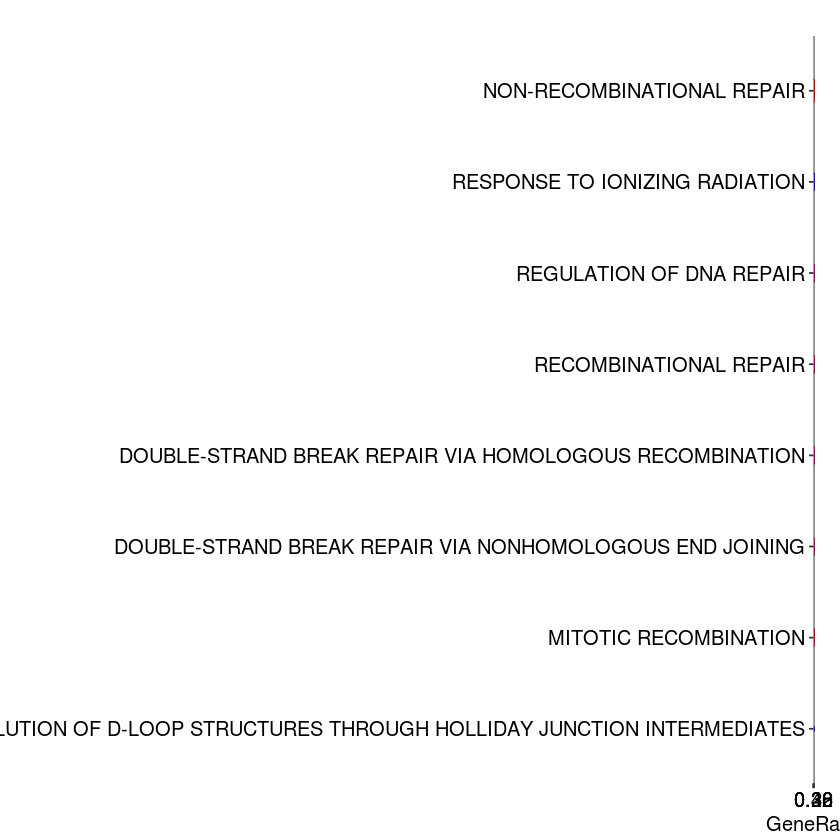

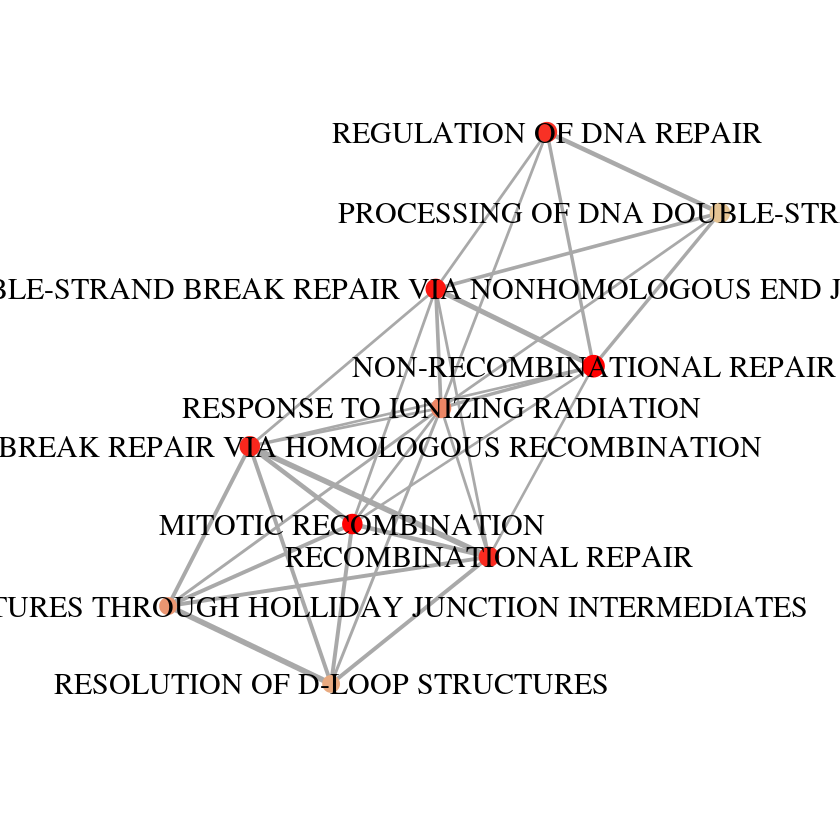

In [5]:
# Hypergeometric
egmt <- enricher(genes, TERM2GENE=gmt, qvalueCutoff=0.1)
head(egmt)

barplot(egmt, showCategory=8)
dotplot(egmt, showCategory=8)
g <- enrichMap(egmt, n=10, vertex.label.font=0.001)

j1 <- toCytoscape(g)
write(j1, "enrich_del.json")


## Get communities (modules)


ebcGenes
    RAD51B       EME1     RAD51D      RAD50       SMC5      RECQL      H2AFX 
0.76470588 0.58823529 0.58823529 0.52941176 0.23529412 0.11764706 0.05882353 
    PAXIP1       SMC6      UIMC1 
0.05882353 0.05882353 0.05882353 

[1] "SMC6"   "RAD51D" "RAD50"  "SMC5"   "RAD51B" "RECQL"  "RAD51D" "RAD50" 
 [9] "SMC5"   "RAD51B" "RECQL"  "RAD51D" "RAD50"  "SMC5"   "RAD51B" "H2AFX" 
[17] "PAXIP1" "UIMC1"  "RAD51D" "RAD51B" "RAD51D" "RAD50"  "EME1"   "RAD51B"
[25] "RAD51D" "RAD50"  "EME1"   "RAD51B" "RAD51D" "RAD50"  "EME1"   "RAD51B"
[33] "RAD51D" "RAD50"  "EME1"   "RAD51B" "RAD51D" "RAD50"  "EME1"   "RAD51B"
[41] "RAD51D" "RAD50"  "EME1"   "RAD51B" "SMC5"   "RAD51B" "RAD51B" "EME1"  
[49] "RAD51B" "EME1"   "EME1"   "EME1"

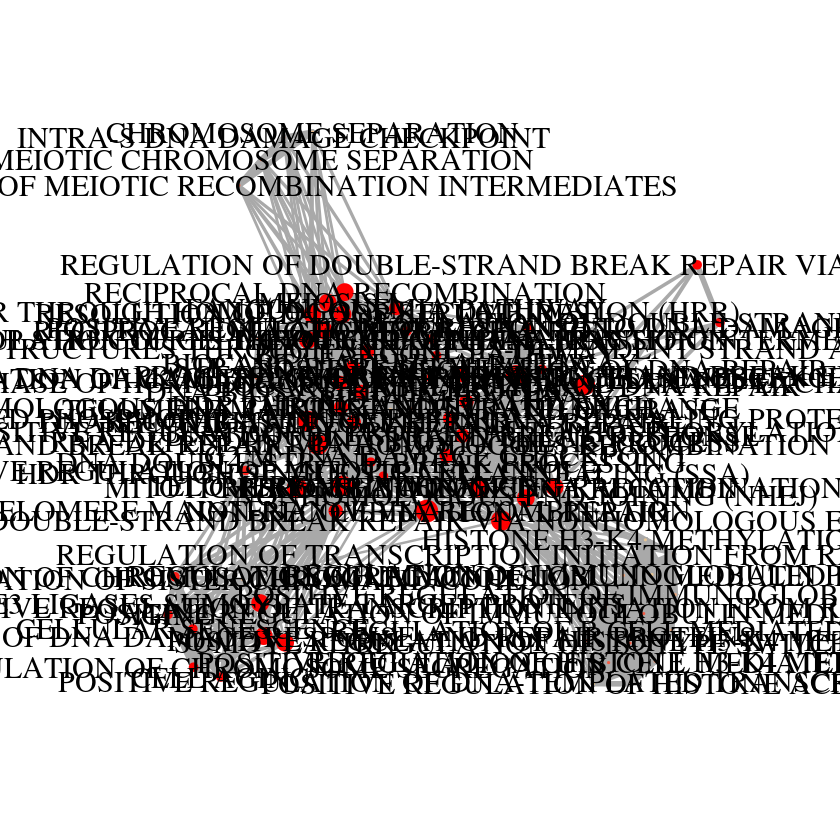

In [6]:
x <- enrichMap(egmt, n=nrow(egmt), vertex.label.font=0.05)
ebc <- cluster_edge_betweenness(x)
ebc <- cluster_fast_greedy(x)
e1 <- membership(ebc)

e1Df <- data.frame(name=names(e1), module=as.numeric(e1), stringsAsFactors = FALSE)

# Largest module
curModule <- as.numeric(names(sort(table(unname(e1)),decreasing=TRUE)[1]))
curModule <- 3

e2 <- names(which(e1 == curModule))

ebcGenes <- NULL
for(i in 1:length(e2)) {
  pattern <- gsub("([.|()\\^{}+$*?]|\\[|\\])", "\\\\\\1", e2[i])
  pattern <- paste0("^", pattern, "%")

  # Grab the first geneset if multiple
  idx <- which(grepl(pattern, names(lovGmt)))[1]

  genesInPathway <- genes[genes %in% lovGmt[[idx]]]

  ebcGenes <- c(ebcGenes, genesInPathway)
}

sort(table(ebcGenes), decreasing=TRUE) / length(e2)
#ebcGenes <- unique(ebcGenes)

# Recurrent words in module and frequency
#wordcloud(corpus, max.words = 25, min.freq=3, random.order = FALSE)
#tf1

# Genes in module
ebcGenes

# Get the gene set name that has the most overlap with the user input
idxM1 <- which(egmt$ID %in% e2)
idxM2 <- which.max(egmt$Count[idxM1])
selectedPathway <- egmt$ID[idxM1][idxM2]